## 1. 사진 준비하기

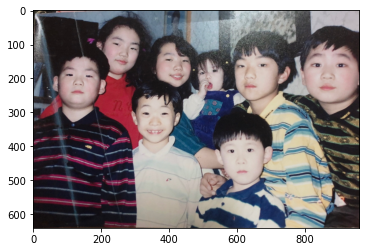

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/lms_project_dataset/EP3/image4.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (960, 640))    # Resize(960, 640)
img_show = img_bgr.copy()      #img_show=카피본, img_bgr=원본 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. Face Detection

In [2]:
# 사진의 얼굴부분 인식
import dlib
detector_hog = dlib.get_frontal_face_detector() # dlib을 활용해 hog detector를 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #dlib은 rgb 이미지를 입력으로 받음
dlib_rects = detector_hog(img_rgb, 1) ## detector를 이용해서 얼굴의 bounding box를 추출

rectangles[[(79, 163) (187, 271)], [(211, 68) (318, 175)], [(306, 271) (414, 378)], [(786, 116) (941, 270)], [(557, 390) (665, 498)], [(366, 116) (474, 223)], [(583, 125) (712, 254)], [(478, 163) (552, 237)]]


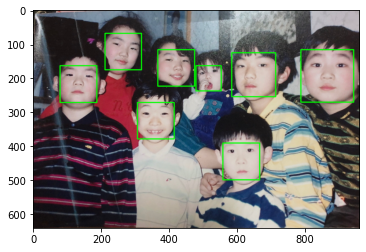

In [3]:
# 이미지 위에 얼굴의 bounding box 출력
print(dlib_rects)   # 얼굴영역 좌표 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. Face Landmark

In [4]:
# 사진속 얼굴들의 landmark불러오기(좌표값으로 표현)
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark 개별 위치 저장 
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    #print(points.parts())
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0])) # 68개의 (x,y) 튜플로 이루어진 리스트

68


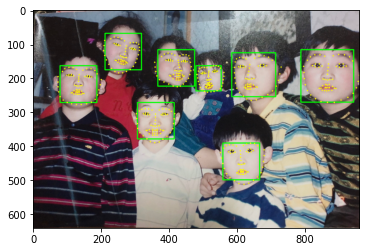

In [5]:
# 랜드마크를 이미지에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4.스티커 적용하기

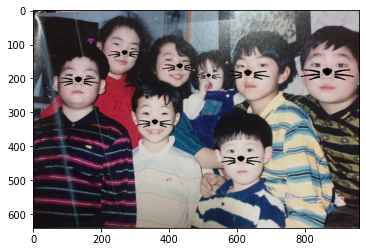

In [6]:
# 인물별로 스티커 적용
# 여러명의 스티커 작업을 하기 위해서 For문 안에서 코드 작성. 
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print (landmark[30]) # nose center index : 30 
    x = landmark[30][0]
    y = landmark[30][1] 
    w = (landmark[14][0]-landmark[2][0]) #왼쪽 오른쪽 빰
    h = (landmark[14][0]-landmark[2][0])
    #print ('(x,y) : (%d,%d)'%(x,y)) # (x,y) : 코
    #print ('(w,h) : (%d,%d)'%(w,h)) #(w,h) : 
    #print("===")
    # 스티커 사이즈조절과 스티커 시작점 설정 
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    #print (img_sticker.shape) #(130, 130, 3)
    plt.imshow(img_sticker)
    refined_x = x - w//2 # left
    refined_y = y - h//2 # top
    #print ('(left,top) : (%d,%d)'%(refined_x, refined_y)) #(x,y)는 스티커 왼쪽위지점임
    # 스티커위치가 사진을 벗어나게 설정되는 경우, 보정 작업 
    if refined_y<0 :
        img_sticker = img_sticker[-refined_y:]
        print (img_sticker.shape) #(77, 130, 3)
        #top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.
        refined_y = 0
        print ('(left,top) : (%d,%d)'%(refined_x, refined_y)) # (x,y) : (282,0)
    else: 
        pass
    #print("refined_x:",refined_x," refined_y:",refined_y)
    # 스티커 붙이기 
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    #print("=============")
# 이미지 출력 
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 프로젝트 정리
스티커 적용 
- 과정: 1)얼굴 인식 -> 2)눈/코/입 인식 -> 3) 스티커 좌표 설정 및 붙임.
- 느낀점: 1) 라이브러리를 활용하여 얼굴을 인식하는 과정은 간단하지만 유용했음 2) 얼굴 기관들의 세부 좌표들을 통해서 디테일한 위치 지정이 가능하다는 점이 흥미로왔음. 3) 사람 얼굴은 인식을 잘하지만, 사람닮은 동물에 대해선 당연하게도 얼굴 인식을 못한다. 

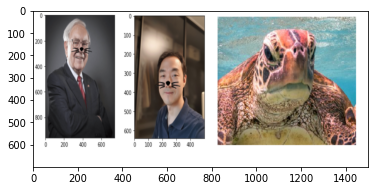

In [7]:
my_image_path1 = os.getenv('HOME')+'/aiffel/lms_project_dataset/EP3/결과.png'
img_bgr1 = cv2.imread(my_image_path1)    
img_bgr1 = cv2.resize(img_bgr1, (1500, 700))  
img_rgb1 = cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb1)
plt.show()